In [1]:
import numpy as np
import h5py
import os, sys
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
import pandas as pd
sys.path.remove(sys.path[0])

sys.path.append('/Users/ajc/Core/codes/simulator/debug/ats/tools/utils/')
#sys.path.append('/Users/ajc/CODES/ats/tools/utils/')
import get_transect_data

sys.path.append('/Users/ajc/Core/PreProcessing/PyScript')
import readdata

In [2]:
path = "/Users/ajc/Core/simulations/barrow_icewedges/hydrologic_connection/ProjectionsG/"

In [3]:
Simulations = [['CESM_C1','CESM_C1A','CESM_C1B'],['CESM_C2'], ['CESM_C3', 'CESM_C3A', 'CESM_C3B', 'CESM_C3C']]
Simulations = [['CESM_C10','CESM_C11'], ['CESM_C30', 'CESM_C31'], ['CESM_C30', 'CESM_C31']]

In [4]:
def getData(i):
    Data = []
    Time = []
    for s in Simulations[i]:
        #print (i, s)
        infile = os.path.join(path,s)
        
        Tim1, Dat1 = get_transect_data.get2DMatrix(infile,varnames=['temperature'])
        a1 = len(Dat1[0,:,0,0])%73
        a2 = len(Dat1[0,:,0,0]) - a1
        
        Tim = Tim1[:a2]
        Dat = Dat1[:,:a2,:,:]
        Time.append(Tim)
        Data.append(Dat)
        #print ('HERE',a1,a2, Tim1.shape)
    d = dict()
    d['temperature'] = Data
    d['time'] = Time
    
    return d

In [5]:
from multiprocessing import Pool
num_processors = 3
p=Pool(processes = num_processors)

DataS1, DataS2, DataS3 = p.map(getData,[i for i in range(len(Simulations))])


3 2762 45 85
3 4734 45 85
3 4734 45 85
3 2263 45 85
3 2263 45 85
3 4234 45 85


In [6]:
Data = [DataS1, DataS2,DataS3]


In [7]:
depth1 = [[0,26],[26,46],[46,54],[54,64],[64,70],[70,75]] # active layer, 0.5-2 m, 2-3.5m
#depth1 = [[0,56]]#,[26,46],[46,54],[54,64],[64,70],[70,75]] # active layer, 0.5-2 m, 2-3.5m

In [8]:
def get_AveTemp_Intervals(dat,season = " ", start=0, end=-1,depth_s=-1,depth_e=-1, yr_cyc=365,domain='entire'):
    #25 * 2cm = 50 cm
    sim_len = len(dat['temperature'])
    
    data = []
    times = []
    HillslopeT = dict()
    AvgTemp = [] # np.zeros(cycles)
    for k in range(sim_len):
        data = np.array(dat['temperature'][k])
        time = dat['time'][k]
    
        nvar, cycles, xnum, znum = data.shape
    
        
        zlen = len(data[1,0,0,:])-1
        xlen = len(data[0,0,:,0])-1
        #print (cycles,zlen,xlen, data[1,0,0,zlen-depth_s],data[1,0,0,zlen-depth_e], data[1,0,0,zlen-depth_e] -data[1,0,0,zlen-depth_s])
        #print (cycles, zlen, xlen, depth_s, depth_e, zlen-depth_s,zlen-depth_e)
        for i in range(cycles):
            sum1 = 0
            for j in range(xlen):
                if 'entire' in domain:
                    sum1 = np.mean(data[nvar-1,i,j,:])
                else:
                    sum1 = np.mean(data[nvar-1,i,j,zlen-depth_e:zlen-depth_s])

            AvgTemp.append(sum1)
        times.append(time)
    L = len(AvgTemp)%int(yr_cyc)
    times = np.concatenate(times)
    #print ('Lengths: ', len(AvgTemp), len(times))
    HillslopeT['times'] = np.array(times)
    HillslopeT_Avg = np.array(AvgTemp)
    
    if L > 0:
        d = np.reshape(HillslopeT_Avg[:-L], (-1,yr_cyc))
        HillslopeT['temp-annual_avg'] = d.mean(axis=1)
        HillslopeT['times_yr'] = np.reshape(times[:-L], (-1,yr_cyc)).mean(axis=1)
        
        d1 = np.zeros(d.shape[0])
        for i in range(d.shape[0]):
            #print (i, d.shape, d[i], d[i][np.where(d[i] > 273.15)])
            d1[i] = d[i][np.where(d[i] > 273.15)].mean(axis=0)
        #print (d1.shape, d.shape)
        HillslopeT['temp-summer_avg'] = d1

    else:
        d = np.reshape(HillslopeT_Avg, (-1,yr_cyc))
        HillslopeT['temp-annual_avg'] = d.mean(axis=1)
        HillslopeT['times_yr'] = np.reshape(times, (-1,yr_cyc)).mean(axis=1)
        d1 = np.zeros(d.shape[0])
        for i in range(d.shape[0]):
            d2 = np.where(d[i] > 273.15, d[i],0)
            #print (d[i], d2, np.array([x for x in d2 if x >0]))
            
            x = np.array([x for x in d2 if x >0])
            if len(x) > 0:
                d1[i] = np.max(x)
            else:
                d1[i] = 273.15
            #print (d1[i])
            #break
        #print (d1.shape, d.shape)
        HillslopeT['temp-summer_avg'] = d1
    #print (HillslopeT['temp-summer_avg'][])
    return HillslopeT


In [9]:
x = np.array([[1,2,3,4,5], [2,3,4,5,6]])
x1 = np.array(x[0][np.where(x[0]>=2)])
print (x1)

[2 3 4 5]


In [10]:
start1_,end1_, = 0,-1
Data_avgTotal = dict()

permafrost = ['top']
Names = ['CESM_C1', 'CESM_C2', 'CESM_C3']
for i in range(len(permafrost)):
    for dat,name in zip(Data,Names):
        #print (name)
        d = get_AveTemp_Intervals(dat,start=start1_,end=end1_,depth_s=depth1[i][1],depth_e=depth1[i][0],yr_cyc=73,domain='entire')
        Data_avgTotal[name + '_' + permafrost[i] + '_temp'] = d['temp-annual_avg']
        Data_avgTotal[name + '_' + permafrost[i] + '_stemp'] = d['temp-summer_avg']
        Data_avgTotal[name + '_' + permafrost[i] +'_time_yr'] = d['times_yr']
        Data_avgTotal[name + '_' + permafrost[i] +'_time'] = d['times']
        #break
#print (Data_avgTotal[Simulations[0] + '_top' + '_temp']/55555.)

In [11]:
start1_,end1_, = 0,-1
Data_avg = dict()

permafrost = ['top', 'shallow', 'deep']#,'deeper', 'deepest','lower']
for i in range(len(permafrost)):
    for dat, name in zip(Data,Names):
        #print (name)
        d = get_AveTemp_Intervals(dat,start=start1_,end=end1_,depth_s=depth1[i][0],depth_e=depth1[i][1],yr_cyc=73, domain="")
        Data_avg[name + '_' + permafrost[i] + '_temp'] = d['temp-annual_avg']
        Data_avg[name + '_' + permafrost[i] + '_stemp'] = d['temp-summer_avg']
        Data_avg[name + '_' + permafrost[i] +'_time_yr'] = d['times_yr']
        Data_avg[name + '_' + permafrost[i] +'_time'] = d['times']

In [12]:
start1_,end1_, = 0,10
Data_avg_wland = dict()
scenarios = ['B', 'S30', 'S60', 'S90']
permafrost = ['top', 'shallow', 'deep','deeper','deepest', 'deepest1']

for i in range(len(depth1)):
    for dat, name in zip(Data,Names):
        d = get_AveTemp_Intervals(dat,start=start1_,end=end1_,depth_s=depth1[i][0],depth_e=depth1[i][1],yr_cyc=73)
        Data_avg_wland[name + '_' + permafrost[i] + '_temp'] = d['temp-annual_avg']
        Data_avg_wland[name + '_' + permafrost[i] +'_time'] = d['times_yr']

In [13]:
start1_,end1_, = 11,-1#-2,-1
Data_avg_uland = dict()

for i in range(len(depth1)):
    for dat, name in zip(Data,Names):
        d = get_AveTemp_Intervals(dat,start=start1_,end=end1_,depth_s=depth1[i][0],depth_e=depth1[i][1],yr_cyc=73)
        Data_avg_uland[name + '_' + permafrost[i] + '_temp'] = d['temp-annual_avg']
        Data_avg_uland[name + '_' + permafrost[i] +'_time'] = d['times_yr']


# Top three zones : Active layer, shallow permafrost, deep permafrost

In [187]:
# Three zones : Active layer, shallow permafrost, deep permafrost
outfile='/Users/ajc/Desktop/maxsnow/'
def Plot_Wetlands_Uplands():
    fig, axs = plt.subplots(1,1, figsize=(6,6), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    TempC = 1*273.15
    plt.tight_layout()
    #axs = axs.ravel()
    xpos = np.array([0, 1,2,3])
    Xticks = [r'S$_{0}$', r'S$_{30}$', r'S$_{60}$', r'S$_{90}$']
    Colors = ['k','b','r','r']
    X = []
    for i,s in enumerate(Names):
        key = s + '_' + permafrost[1] +'_stemp'
        key_t = s + '_' + permafrost[1] +'_time_yr'
        
        #X = [x - TempC for x in Data_avgTotal[key]]
        #T = Data_avgTotal[key_t]
        #axs.plot(T,X,color=Colors[i],label=key)
        
        X = [x - TempC for x in Data_avg[key]]
        print (np.mean(X[-10:]))
        T = Data_avg[key_t]
        axs.plot(T,X,color=Colors[i],label=key)

    axs.set_ylabel('Water content',fontsize=10, fontweight='normal')
    axs.legend()
    axs.set_xlim(50,)
    #axs.set_ylim(1,)
    plt.show()


4.2775894304180495
4.970583853049805
4.440909595660855


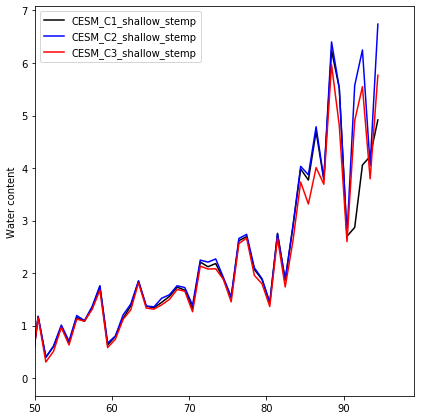

In [188]:
Plot_Wetlands_Uplands()

<BarContainer object of 3 artists>

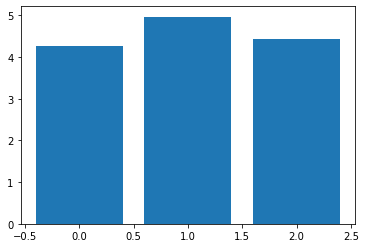

In [190]:
plt.bar([0,1,2],[4.2775894304180495,4.970583853049805,4.440909595660855])

In [ ]:
key_evap = 'surface-evaporative_flux'
def getSurfaceData(i):
    Data = []
    #Time = []
    
    for s in Simulations[i]:
        #print (i, s)
        infile = os.path.join(path,s,'visdump_surface_data.h5')
        
        #Dat1 = np.array(readdata.GetSurfVarFromVis(infile,key_evap,cellid=-1)[key_evap])
        Dat11 = np.array(readdata.GetSurfVarFromVis_All(infile,key_evap)[key_evap])
        Dat1 = Dat11.sum(axis=1)*86400*1000/46
        #print (Dat1)
        a1 = len(Dat1)%73
        a2 = len(Dat1) - a1
        
        #Tim = Tim1[:a2]
        Dat = Dat1
        #Time.append(Tim)
        Data.append(Dat)
        #print ('HERE',a1,a2, Tim1.shape)
    d = dict()
    d[key_evap] = np.concatenate(Data)
    
    
    return d

In [ ]:
from multiprocessing import Pool
num_processors = 3
p=Pool(processes = num_processors)

DataSurf1, DataSurf2, DataSurf3 = p.map(getSurfaceData,[i for i in range(len(Simulations))])

In [ ]:
print (len(DataSurf1[key_evap])*5)
X = np.linspace(0,365,73)
plt.plot(X,DataSurf1[key_evap][-73*2:-73],'k')
plt.plot(X,DataSurf2[key_evap][-73*2:-73],'b')
plt.plot(X,DataSurf3[key_evap][-73*2:-73],'r')
#find one dry year, one wet year and one average year, and one time 100-year time serious 2x2 plots

# Deeper zones : Deep_1, Deeper permafrost, Deepest permafrost

In [ ]:
d=h5py.File(os.path.join(path, Simulations[0] ,'visdump_surface_data.h5'),'r')
key_evap =  'surface-water_content.cell.0'
print (d.keys())
d1=d[key_evap]
#d2=d['surface-molar_density_liquid.cell.0']

cycles = sorted(d1.keys(),key=int)
SimS0 = []
for c in cycles:
    SimS0.append(d['surface-water_content.cell.0'][c]) 

In [ ]:
d=h5py.File(os.path.join(path, Simulations[3] ,'visdump_surface_data.h5'),'r')
d1=d[key_evap]
#d2=d['surface-molar_density_liquid.cell.0']

cycles = sorted(d1.keys(),key=int)
SimS1 = []
for c in cycles:
    SimS1.append(d['surface-water_content.cell.0'][c]) 

In [ ]:
plt.plot(SimS0,'r')
plt.plot(SimS1,'r')

# Soil Temperature at x=0 (center of the pond) depth 56 cm

In [ ]:
import datetime as DT
import matplotlib.dates as mdates
def get_time_format(dat): 
    Dat = [] 
    year = int(dat[0]) 
    year_start = DT.date(year,1,1) 
    dateFormatted = year_start.strftime("%b")[0] 
    #print (dat)
    for i in dat: 
        f = float(i) 
        delta = year_start + DT.timedelta(days = int((i-year)*365) ) 
        Dat.append(delta) 
        #print (i,year_start, len(dat), len(Dat)) 
    return Dat

In [ ]:
z1=26
Data_ts_wland = dict() #ts: time series

x=0
for s in scenarios:
    d,_ = get_Temp_timeseries_location(s,location=x,depth=z1)
    Data_ts_wland[s + '_' + str(x) + '_temp'] = d['temp']
    Data_ts_wland[s + '_' + str(x) +'_time'] = [2000 + t for t in d['times']]

Data_ts_uland = dict() #ts: time series
x=49
for s in scenarios:
    d,_ = get_Temp_timeseries_location(s,location=x,depth=z1)
    Data_ts_uland[s + '_' + str(x) + '_temp'] = d['temp']
    Data_ts_uland[s + '_' + str(x) +'_time'] = [2000 + t for t in d['times']]

In [ ]:
Time = get_time_format(Data_ts_wland['B_0_time'][-365:])

In [ ]:
# Three zones : Active layer, shallow permafrost, deep permafrost
outfile='/Users/ajc/Desktop/maxsnow/'
def Plot_X0_X50():
    fig, axs = plt.subplots(1,2, figsize=(6,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    TempC = 273.15
    color=['k', 'g','b','r']
    xfmt = mdates.DateFormatter('%b')
    
    plt.tight_layout()
    axs = axs.ravel()
    xpos = np.array([0, 1,2,3])
    Xticks = [r'S$_{0}$', r'S$_{30}$', r'S$_{60}$', r'S$_{90}$']
    
    ax1=plt.subplot(121)
    X = [Data_ts_wland['B_0_temp'][-1], Data_ts_wland['S30_0_temp'][-1],Data_ts_wland['S60_0_temp'][-1],Data_ts_wland['S90_0_temp'][-1]]
    X = [x-TempC for x in X]
    for i,x in enumerate(X):
        ax1.plot(Time, x,color=color[i],label=Xticks[i])
    ax1.set_ylabel(u'Soil temperature [\u00B0C]',fontsize=12, fontweight='normal')
    ax1.set_xlabel('Time [month]',fontsize=12, fontweight='normal')
    
    ax1.set_ylim((-5, 1))
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.set_xticks(Time[::60])
    #ax1.set_title('Wetland',fontweight='normal')
    ax1.text('2018-09-15',1.15, 'Location: x=0 m, depth=56 cm',fontsize=10, fontweight='normal')
    ax1.legend(loc='lower left', fontsize=8,labelspacing=0.01)#,bbox_to_anchor=(0.9,-0.01, .1, .1))
    ax1.set_xlim('2018-09-17','2019-09-16')
    plt.tight_layout()
    
    # Up land
    ax2=plt.subplot(122)
    X = [Data_ts_uland['B_49_temp'][-1], Data_ts_uland['S30_49_temp'][-1],Data_ts_uland['S60_49_temp'][-1],Data_ts_uland['S90_49_temp'][-1]]
    X = [x-TempC for x in X]
    for i,x in enumerate(X):
        ax2.plot(Time,x,color=color[i],label=Xticks[i])

    
    ax2.xaxis.set_major_formatter(xfmt)
    ax2.set_xticks(Time[::60])
    ax2.set_xlim('2018-09-17','2019-09-16')
    #ax2.set_title('Upland',fontweight='normal')
    ax2.text('2018-09-15', 1.3, 'Location: x=50 m, depth=56 cm',fontsize=10, fontweight='normal')
    ax2.set_xlabel('Time [month]',fontsize=12, fontweight='normal')
    ax2.set_ylim((-17, 1))
    
    #ax2.set_yticks(np.linspace(-17,1,4))
    plt.tight_layout()
    
       
    ax2.legend(loc='lower left', fontsize=8,labelspacing=0.01)#,bbox_to_anchor=(0.9,-0.01, .1, .1))
    #plt.tight_layout()
    
    plt.savefig(outfile+'ts-x0-x50-new.pdf', bbox_inches='tight', dpi=100)
    

In [ ]:
Plot_X0_X50()